In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get Training Data


In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
 class_index = train_data.class_to_idx
 class_index

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Visualize the Images

Image shape: torch.Size([1, 28, 28]) 
The label: 0 
Class: T-shirt/top


(-0.5, 27.5, 27.5, -0.5)

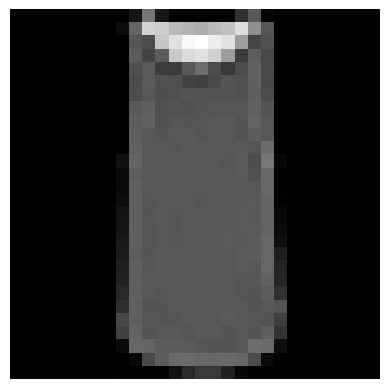

In [7]:
img, label = train_data[2]
print(f"Image shape: {img.shape} \nThe label: {label} \nClass: {class_names[label]}")
plt.imshow(img.squeeze(), cmap="gray")
plt.axis(False)

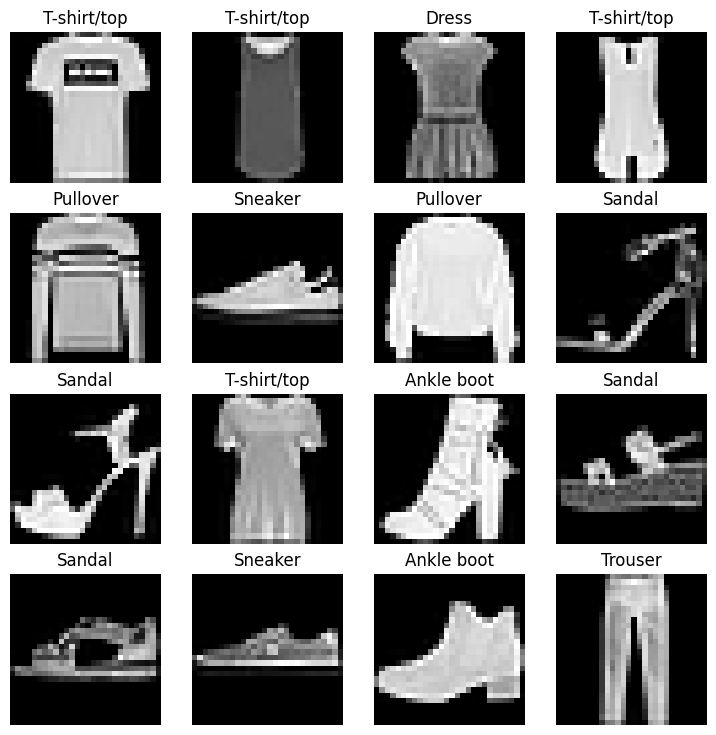

In [8]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

### Create the DataLoader

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [10]:
train_features_batch, train_label_batch = next(iter(train_dataloader))
train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Building a CNN Model

In [11]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_shape,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_shape*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [12]:
model = CNNModel(input_shape=1, hidden_shape=128, output_shape=len(class_names)).to(device)

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [15]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [16]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [17]:
epochs = 4

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_func,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model,
               data_loader=test_dataloader,
               loss_fn=loss_func,
               accuracy_fn=accuracy_fn,
               device=device)

Epoch: 0
-------
Train loss: 2.39180 | Train accuracy: 10.02%
Test loss: 2.30282 | Test accuracy: 10.01%

Epoch: 1
-------
Train loss: 2.30405 | Train accuracy: 10.04%
Test loss: 2.30327 | Test accuracy: 10.00%

Epoch: 2
-------
Train loss: 2.30375 | Train accuracy: 10.03%
Test loss: 2.30347 | Test accuracy: 9.98%

Epoch: 3
-------
Train loss: 2.30415 | Train accuracy: 9.87%
Test loss: 2.30401 | Test accuracy: 10.01%

